# Federated Learning Test
Test federated learning with real data across simulated nodes

In [8]:
import sys
sys.path.insert(0, '../src')

import logging
import torch
import torch.nn as nn
from torch.optim import Adam

from federated_health_risk.data.federated_loader import prepare_federated_data
from federated_health_risk.models.multimodal_model import MultimodalRiskNet

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

## 1. Load Federated Data

In [9]:
# Prepare data for 3 nodes
NUM_NODES = 3
node_loaders = prepare_federated_data(num_nodes=NUM_NODES, strategy="iid", data_root="../data/processed")

# Get dimensions
_, _, (vitals_dim, air_dim, weather_dim) = node_loaders[0]
print(f"\nModel input dimensions:")
print(f"  Vitals: {vitals_dim}")
print(f"  Air Quality: {air_dim}")
print(f"  Weather: {weather_dim}")

INFO:federated_health_risk.data.federated_loader:Loading processed data from ..\data\processed


INFO:federated_health_risk.data.federated_loader:Loaded: Fitbit=940, Air=940, Weather=940 rows
INFO:federated_health_risk.data.federated_loader:Synthetic merged dataset: 940 rows, 19 columns
INFO:federated_health_risk.data.federated_loader:Risk distribution: 25.00% high-risk samples
c:\Users\Sahal Saeed\Documents\7semester\mlops\project_cursor\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
INFO:federated_health_risk.data.federated_loader:Node 0: 314 samples, risk=24.52%
INFO:federated_health_risk.data.federated_loader:Node 1: 313 samples, risk=24.92%
INFO:federated_health_risk.data.federated_loader:Node 2: 313 samples, risk=25.56%
INFO:federated_health_risk.data.federated_loader:Node 0 ready: 8 train batches, 2 test batches
INFO:federated_health_risk.data.federated_loader:Node 1 ready: 8 train batches, 2 test batches
I


Model input dimensions:
  Vitals: 6
  Air Quality: 5
  Weather: 4


## 2. Initialize Models for Each Node

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model for each node
node_models = {}
node_optimizers = {}

for node_id in range(NUM_NODES):
    model = MultimodalRiskNet(vitals_dim=vitals_dim, air_dim=air_dim, text_dim=weather_dim)
    model = model.to(device)
    node_models[node_id] = model
    node_optimizers[node_id] = Adam(model.parameters(), lr=1e-3)

print(f"\nInitialized {NUM_NODES} models")
print(f"Total parameters per model: {sum(p.numel() for p in node_models[0].parameters()):,}")

Using device: cpu

Initialized 3 models
Total parameters per model: 43,521


## 3. Federated Training Loop

In [11]:
def train_node(model, optimizer, train_loader, device, epochs=1):
    """Train a single node's model."""
    model.train()
    criterion = nn.BCELoss()
    total_loss = 0.0
    
    for epoch in range(epochs):
        for batch in train_loader:
            vitals, air, weather, y = [b.to(device) for b in batch]
            
            optimizer.zero_grad()
            preds = model(vitals, air, weather).squeeze()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
    
    return total_loss / (len(train_loader) * epochs)


def evaluate_node(model, test_loader, device):
    """Evaluate a single node's model."""
    model.eval()
    criterion = nn.BCELoss()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            vitals, air, weather, y = [b.to(device) for b in batch]
            preds = model(vitals, air, weather).squeeze()
            loss = criterion(preds, y)
            
            total_loss += loss.item() * y.size(0)
            correct += ((preds > 0.5) == (y > 0.5)).sum().item()
            total += y.size(0)
    
    return total_loss / total, correct / total


def federated_averaging(models):
    """Average model parameters across all nodes (FedAvg)."""
    # Get state dict from first model
    global_state = models[0].state_dict()
    
    # Average each parameter
    for key in global_state.keys():
        global_state[key] = torch.stack([models[i].state_dict()[key].float() for i in range(len(models))]).mean(0)
    
    # Update all models with averaged parameters
    for model in models:
        model.load_state_dict(global_state)
    
    return global_state

In [12]:
# Federated training
NUM_ROUNDS = 5
LOCAL_EPOCHS = 2

print(f"Starting Federated Training: {NUM_ROUNDS} rounds, {LOCAL_EPOCHS} local epochs\n")
print("=" * 70)

history = {"train_loss": [], "test_loss": [], "test_acc": []}

for round_num in range(NUM_ROUNDS):
    print(f"\nRound {round_num + 1}/{NUM_ROUNDS}")
    print("-" * 70)
    
    # Local training on each node
    round_train_losses = []
    for node_id in range(NUM_NODES):
        train_loader, _, _ = node_loaders[node_id]
        train_loss = train_node(
            node_models[node_id], 
            node_optimizers[node_id], 
            train_loader, 
            device, 
            epochs=LOCAL_EPOCHS
        )
        round_train_losses.append(train_loss)
        print(f"  Node {node_id}: train_loss={train_loss:.4f}")
    
    # Federated averaging
    global_state = federated_averaging(list(node_models.values()))
    
    # Global evaluation
    round_test_losses = []
    round_test_accs = []
    for node_id in range(NUM_NODES):
        _, test_loader, _ = node_loaders[node_id]
        test_loss, test_acc = evaluate_node(node_models[node_id], test_loader, device)
        round_test_losses.append(test_loss)
        round_test_accs.append(test_acc)
    
    avg_train_loss = sum(round_train_losses) / len(round_train_losses)
    avg_test_loss = sum(round_test_losses) / len(round_test_losses)
    avg_test_acc = sum(round_test_accs) / len(round_test_accs)
    
    history["train_loss"].append(avg_train_loss)
    history["test_loss"].append(avg_test_loss)
    history["test_acc"].append(avg_test_acc)
    
    print(f"\n  Global Metrics:")
    print(f"    Avg Train Loss: {avg_train_loss:.4f}")
    print(f"    Avg Test Loss:  {avg_test_loss:.4f}")
    print(f"    Avg Test Acc:   {avg_test_acc:.4f}")

print("\n" + "=" * 70)
print("Federated Training Complete!")
print("=" * 70)

Starting Federated Training: 5 rounds, 2 local epochs


Round 1/5
----------------------------------------------------------------------
  Node 0: train_loss=0.4002
  Node 1: train_loss=0.3956
  Node 2: train_loss=0.3244

  Global Metrics:
    Avg Train Loss: 0.3734
    Avg Test Loss:  0.5025
    Avg Test Acc:   0.9101

Round 2/5
----------------------------------------------------------------------
  Node 0: train_loss=0.3440
  Node 1: train_loss=0.3455
  Node 2: train_loss=0.3288

  Global Metrics:
    Avg Train Loss: 0.3394
    Avg Test Loss:  0.2024
    Avg Test Acc:   0.9418

Round 3/5
----------------------------------------------------------------------
  Node 0: train_loss=0.1780
  Node 1: train_loss=0.1612
  Node 2: train_loss=0.1599

  Global Metrics:
    Avg Train Loss: 0.1664
    Avg Test Loss:  0.1158
    Avg Test Acc:   0.9683

Round 4/5
----------------------------------------------------------------------
  Node 0: train_loss=0.1130
  Node 1: train_loss=0.0982
  Node 2:

## 4. Visualize Results

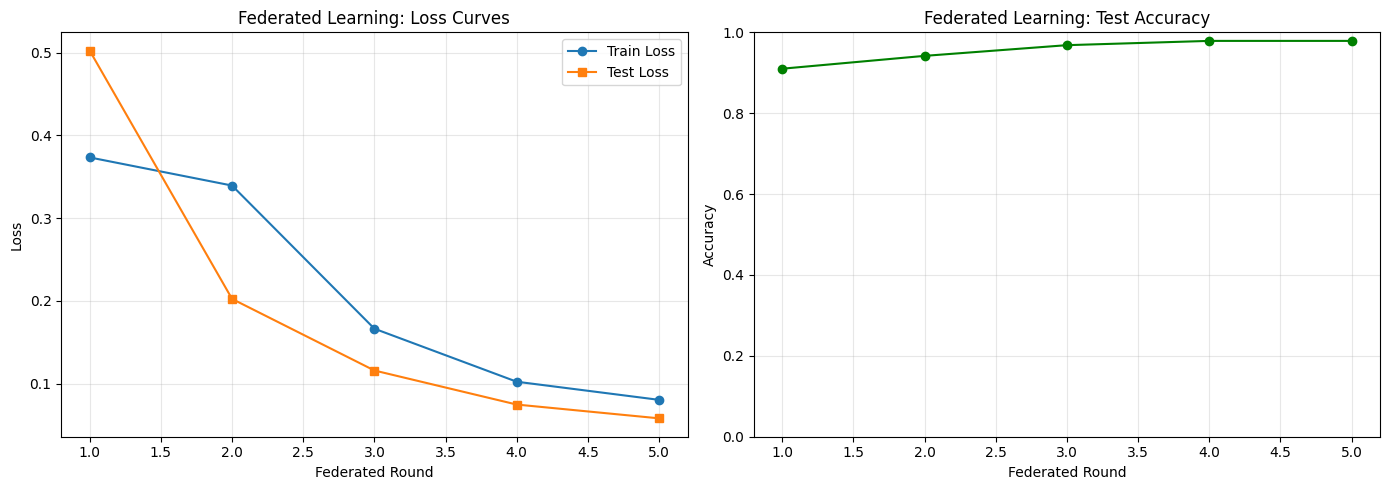


Final Results:
  Test Accuracy: 0.9788
  Test Loss: 0.0580


In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(range(1, NUM_ROUNDS + 1), history["train_loss"], marker='o', label="Train Loss")
ax1.plot(range(1, NUM_ROUNDS + 1), history["test_loss"], marker='s', label="Test Loss")
ax1.set_xlabel("Federated Round")
ax1.set_ylabel("Loss")
ax1.set_title("Federated Learning: Loss Curves")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(range(1, NUM_ROUNDS + 1), history["test_acc"], marker='o', color='green')
ax2.set_xlabel("Federated Round")
ax2.set_ylabel("Accuracy")
ax2.set_title("Federated Learning: Test Accuracy")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig("../models/federated_training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal Results:")
print(f"  Test Accuracy: {history['test_acc'][-1]:.4f}")
print(f"  Test Loss: {history['test_loss'][-1]:.4f}")

## 5. Save Global Model

In [14]:
# Save the global model
torch.save({
    'model_state_dict': node_models[0].state_dict(),
    'vitals_dim': vitals_dim,
    'air_dim': air_dim,
    'weather_dim': weather_dim,
    'history': history,
    'num_rounds': NUM_ROUNDS,
    'num_nodes': NUM_NODES
}, '../models/federated_global_model.pth')

print("Global model saved to: models/federated_global_model.pth")

Global model saved to: models/federated_global_model.pth
